# RNN 
the dataset used for this notebook is from the max planck institute for Biogeochemistry. It is called The Jena Climate dataset.

## Imports

***mount drive***

In [ ]:
from google.colab import drive 
drive.mount("/content/drive")

Mounted at /content/drive


***general imports***

In [ ]:
import pandas as pd
import numpy as np 
import random 
import matplotlib.pyplot as plt 
from zipfile import ZipFile
import os

***sklearn imports***

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

***keras & tensorflow imports***

In [ ]:
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, SimpleRNN

***unzip file***

In [ ]:
with ZipFile("/content/drive/MyDrive/Youtube/6 - RNN-simple/jena_climate_2009_2016.zip") as zipObj:
  zipObj.extractall("/content/drive/MyDrive/Youtube/6 - RNN-simple/dataset")

## Load Data

***load .csv file***

In [ ]:
dataset_path = "/content/drive/MyDrive/Youtube/6 - RNN-simple/dataset/jena_climate_2009_2016.csv"

dataframe = pd.read_csv(dataset_path)

dataframe.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


***delete all columns except temperature (because we want a uni-variate model)***

In [ ]:
dataframe = dataframe[["T (degC)"]]

dataframe.head()

,T (degC)
0,-8.02
1,-8.41
2,-8.51
3,-8.31
4,-8.27


## Pre-Process Data

***scale data (min-max)***

In [ ]:
scaler = MinMaxScaler()

# applying the transformation and also changing the name from "T (degC)" to "T"
dataframe = pd.DataFrame(scaler.fit_transform(dataframe), columns = ["T"])

dataframe.head()

,T
0,0.248632
1,0.242163
2,0.240504
3,0.243822
4,0.244485


***convert dataframe to numpy-array***

In [ ]:
y_list = list(dataframe["T"])

# number of future data
n_future = 72

# number of past data
n_past = 3*72

# number of all data
total_period = 4*72

end_index = len(y_list)
start_index = end_index - total_period

# initialize feature and target arrays
X = []
y = []

while start_index > 0:

  X_line = y_list[start_index:start_index+n_past]
  y_line = y_list[start_index+n_past:start_index+total_period]

  X.append(X_line)
  y.append(y_line)

  start_index -= 1

X = np.array(X)
y = np.array(y)

print(X.shape)
print(y.shape)

(420263, 216)
(420263, 72)


***test/train split***

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(378236, 216)
(378236, 72)


## Build Model Architecture

we define three different models here:
1. Simple-RNN
2. GRU - 1 Gated
3. GRU - 3 Gated

***define constants - input format of RNN = (n_samples, n_timesteps, n_features)***

In [ ]:
# test batch size (make it smaller for better results)
batch_size = 2048

# number of samples 
n_samples = X_train.shape[0]

# number of time steps 
n_timesteps = X_train.shape[1]

# number of steps 
n_steps = y_train.shape[1]

# number of features 
n_features = 1

# re-shape X_train and X_test to a valid shape for input
X_train = X_train.reshape(-1, n_timesteps, n_features)
X_test = X_test.reshape(-1, n_timesteps, n_features)

***simple-RNN unit structure***

In [ ]:
random.seed(420)

model_1 = Sequential([
    SimpleRNN(8, activation="tanh", input_shape=(n_timesteps, n_features), return_sequences=True),
    SimpleRNN(8, activation="tanh", return_sequences=True), 
    SimpleRNN(8, activation="tanh"), 
    Dense(y_train.shape[1]), 
])

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 216, 8)            80        
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 216, 8)            136       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 8)                 136       
                                                                 
 dense (Dense)               (None, 72)                648       
                                                                 
Total params: 1,000
Trainable params: 1,000
Non-trainable params: 0
_________________________________________________________________


***1 Gated Recurrent Unit Structure***

In [ ]:
random.seed(69)
from tensorflow.keras.layers import GRU

model_2 = Sequential([
    GRU(8, activation="tanh", input_shape=(n_timesteps, n_features)), 
    Dense(y_train.shape[1]), 
])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 8)                 264       
                                                                 
 dense_1 (Dense)             (None, 72)                648       
                                                                 
Total params: 912
Trainable params: 912
Non-trainable params: 0
_________________________________________________________________


***3 Gated Recurrent Unit Structure***

In [ ]:
random.seed(85)

model_3 = Sequential([
    GRU(10, activation="tanh", input_shape=(n_timesteps, n_features), return_sequences=True), 
    GRU(10, activation="tanh", return_sequences=True), 
    GRU(10, activation="tanh"), 
    Dense(y_train.shape[1]), 
])

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 216, 10)           390       
                                                                 
 gru_2 (GRU)                 (None, 216, 10)           660       
                                                                 
 gru_3 (GRU)                 (None, 10)                660       
                                                                 
 dense_2 (Dense)             (None, 72)                792       
                                                                 
Total params: 2,502
Trainable params: 2,502
Non-trainable params: 0
_________________________________________________________________


## Compile and Train Model

we compile and train the three models we just built

***compile all three models***

In [ ]:
from tensorflow.keras.optimizers import Adam

model_1.compile(loss="mean_absolute_error", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])
model_2.compile(loss="mean_absolute_error", optimizer=Adam(learning_rate=0.1), metrics=["accuracy"])
model_3.compile(loss="mean_absolute_error", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

***train model 1***

In [ ]:
history_1 = model_1.fit(X_train, y_train, validation_split=0.2, epochs=5, batch_size=batch_size, shuffle=True)

Epoch 1/5
148/148 [==============================] - 108s 700ms/step - loss: 0.0488 - accuracy: 0.0477 - val_loss: 0.0442 - val_accuracy: 0.0560
Epoch 2/5
148/148 [==============================] - 93s 631ms/step - loss: 0.0438 - accuracy: 0.0601 - val_loss: 0.0435 - val_accuracy: 0.0395
Epoch 3/5
148/148 [==============================] - 87s 587ms/step - loss: 0.0435 - accuracy: 0.0576 - val_loss: 0.0436 - val_accuracy: 0.0547
Epoch 4/5
148/148 [==============================] - 88s 592ms/step - loss: 0.0434 - accuracy: 0.0815 - val_loss: 0.0432 - val_accuracy: 0.0373
Epoch 5/5
148/148 [==============================] - 85s 574ms/step - loss: 0.0428 - accuracy: 0.0869 - val_loss: 0.0424 - val_accuracy: 0.1195


***train model 2***

In [ ]:
history_2 = model_2.fit(X_train, y_train, validation_split=0.2, epochs=5, batch_size=batch_size, shuffle=True)

Epoch 1/5
148/148 [==============================] - 7s 23ms/step - loss: 0.0599 - accuracy: 0.0577 - val_loss: 0.0470 - val_accuracy: 0.0293
Epoch 2/5
148/148 [==============================] - 3s 17ms/step - loss: 0.0450 - accuracy: 0.0686 - val_loss: 0.0427 - val_accuracy: 0.1621
Epoch 3/5
148/148 [==============================] - 2s 15ms/step - loss: 0.0434 - accuracy: 0.0709 - val_loss: 0.0424 - val_accuracy: 0.1041
Epoch 4/5
148/148 [==============================] - 2s 15ms/step - loss: 0.0429 - accuracy: 0.0931 - val_loss: 0.0426 - val_accuracy: 0.1145
Epoch 5/5
148/148 [==============================] - 2s 16ms/step - loss: 0.0443 - accuracy: 0.0833 - val_loss: 0.0318 - val_accuracy: 0.1600


***train model 3***

In [ ]:
history_3 = model_3.fit(X_train, y_train, validation_split=0.2, epochs=5, batch_size=batch_size, shuffle=True)

Epoch 1/5
148/148 [==============================] - 66s 54ms/step - loss: 0.2217 - accuracy: 0.0083 - val_loss: 0.0558 - val_accuracy: 0.0091
Epoch 2/5
148/148 [==============================] - 7s 46ms/step - loss: 0.0501 - accuracy: 0.0097 - val_loss: 0.0484 - val_accuracy: 0.0107
Epoch 3/5
148/148 [==============================] - 7s 46ms/step - loss: 0.0477 - accuracy: 0.0140 - val_loss: 0.0473 - val_accuracy: 0.0158
Epoch 4/5
148/148 [==============================] - 7s 46ms/step - loss: 0.0467 - accuracy: 0.0184 - val_loss: 0.0464 - val_accuracy: 0.0169
Epoch 5/5
148/148 [==============================] - 7s 46ms/step - loss: 0.0457 - accuracy: 0.0256 - val_loss: 0.0453 - val_accuracy: 0.0219


## Evaluate Model Performance 

***plot loss over iterations model-1***

1314/1314 [==============================] - 70s 53ms/step


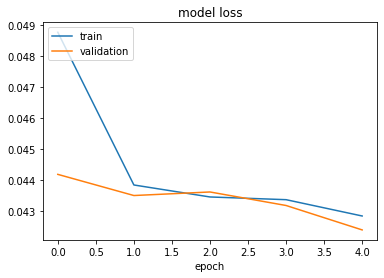

In [ ]:
predictions_1 = model_1.predict(X_test)

plt.plot(history_1.history["loss"])
plt.plot(history_1.history["val_loss"])

plt.title("model loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

***r2 score of the 1st model***

In [ ]:
print(r2_score(predictions_1, y_test))

0.7089662393844345


***plot loss over iterations model-2***

1314/1314 [==============================] - 6s 4ms/step


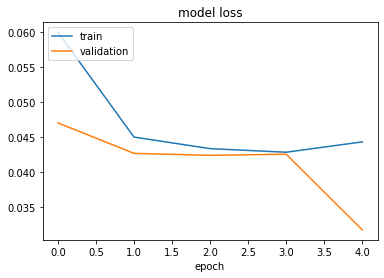

In [ ]:
predictions_2 = model_2.predict(X_test)

plt.plot(history_2.history["loss"])
plt.plot(history_2.history["val_loss"])

plt.title("model loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

***r2 score of the 2nd model***

In [ ]:
print(r2_score(predictions_2, y_test))

0.8830766358846007


***plot loss over iterations model-3***

1314/1314 [==============================] - 11s 8ms/step


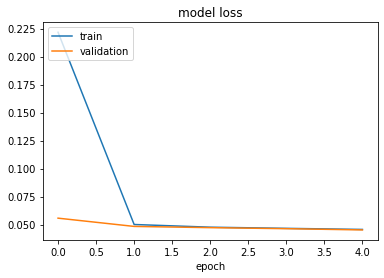

In [ ]:
predictions_3 = model_3.predict(X_test)

plt.plot(history_3.history["loss"])
plt.plot(history_3.history["val_loss"])

plt.title("model loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

***r2 score of the 3rd model***

In [ ]:
print(r2_score(predictions_3, y_test))

0.6647633305668911
